# Práctica 3

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import signal
import cv2

### Funciones generales:

In [5]:
def cargar(nombre):
    img = Image.open(nombre).convert(mode='L')
    return np.array(img)


def mostrar(imagen, titulo=""):
    plt.figure(figsize=(9, 9))
    if (titulo): plt.title(titulo)
    plt.imshow(imagen, cmap='gray', vmin=0, vmax=255)


def pasarALog(imagen):
    c = 255 / np.log(1 + np.max(imagen))
    resultado = np.uint8(c * np.log(1 + imagen))
    return resultado


# valor entre 0 y 255
def aplicar_umbral(imagen, valor):
    return np.uint8(np.greater(imagen, valor) * 255)


# suavizado:
def suavizado_promedio(imagen, dimension):
    H = np.ones((dimension, dimension)) / dimension ** 2
    return signal.convolve2d(imagen, H, boundary="symm", mode="same")


def eqHist(imagen):
    hist = np.histogram(imagen, 256, range=(0, 256))
    acumulado = np.cumsum(hist[0])
    normalizado = 255 * ((acumulado - acumulado.min()) / (acumulado.max() - acumulado.min()))
    resultado = np.uint8(normalizado[imagen])
    return resultado


def ventana_gauss(dimension, desviacion):
    gauss1d = signal.windows.gaussian(dimension, desviacion)
    gauss2d = np.outer(gauss1d, gauss1d)
    return gauss2d / sum(sum(gauss2d))


def suavizado_gauss(imagen, std):
    gauss = ventana_gauss(int(4 * std), std)
    return signal.convolve2d(imagen, gauss, boundary="symm", mode="same")


def bordes_gradiente(imagen, umbral, metodo="roberts"):
    #roberts:
    h1 = np.array([[-1., 0.], [0., 1.]])
    h2 = np.flip(h1, axis=1)

    if metodo == "prewitt":
        h1 = np.array([[-1., -1., -1.], [0., 0., 0.], [1., 1., 1.]])
        h2 = h1.T

    if metodo == "sobel":
        h1 = np.array([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]])
        h2 = h1.T

    im1 = signal.convolve2d(imagen, h1, boundary="symm", mode="same")
    im2 = signal.convolve2d(imagen, h2, boundary="symm", mode="same")

    imagen_res = np.abs(im1) + np.abs(im2)

    return aplicar_umbral(imagen_res, umbral)


### Detección de rectas

In [6]:

video = cv2.VideoCapture("camino1.avi")
fps = video.get(cv2.CAP_PROP_FPS)
_, frame = video.read()

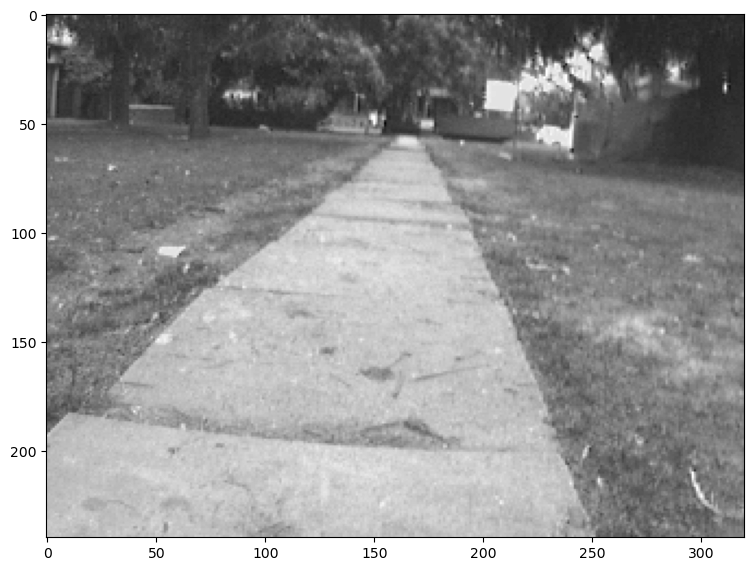

In [7]:
frame1 = frame[:, :, 0]
mostrar(frame1)

In [8]:
fps

25.0

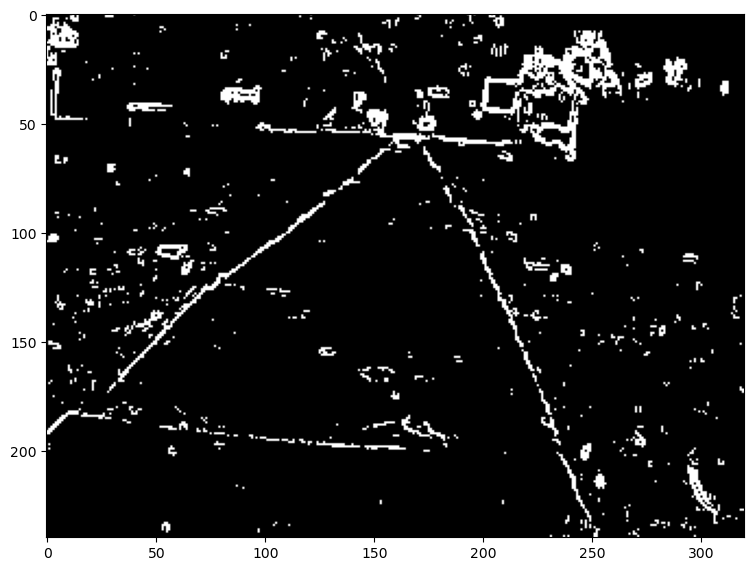

In [9]:
mostrar(bordes_gradiente(frame1, 200, "sobel"))

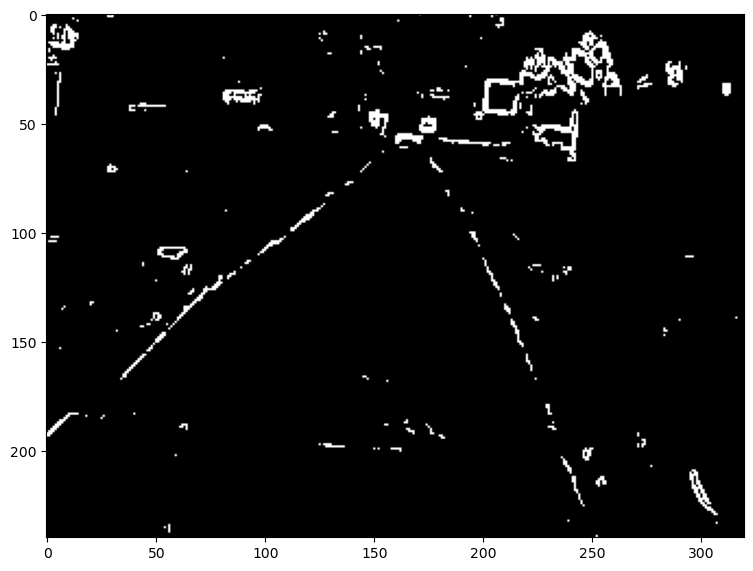

In [10]:
mostrar(bordes_gradiente(suavizado_gauss(frame1, 0.5), 240, "sobel"))

In [29]:
#funcion:

def detecta_rectas(imagen, umbral_angulo = 10, cant_rectas = 2, muestra_matriz = False):
    #detección de bordes:
    bordes = bordes_gradiente(suavizado_gauss(imagen, 0.5), 200, "sobel")
    maximo = ((np.shape(bordes)[0] ** 2 + np.shape(bordes)[1] ** 2) ** (1 / 2)) + 1
    maximo = np.int32(maximo)
    donde = np.nonzero(bordes)
    angulos = np.linspace(-np.pi / 2, np.pi / 2, 181)
    
    #matriz de acumulacion:
    A = np.zeros((maximo * 2, np.size(angulos)), dtype=np.int32)

    it = np.nditer(angulos, flags=["c_index"])
    for ang in it:
        rhos = np.int32(np.round((donde[0] + 1) * np.cos(ang) + (donde[1] + 1) * np.sin(ang))) + maximo
        cantidades = np.bincount(rhos)
        cantidades.resize(np.shape(A)[0])
        A[:, it.index] = cantidades

    max_ocurrencia = A.max()
    #lineas con maxima ocurrencia:
    lineas = np.where(A > max_ocurrencia * 0.50)
    tabla_lineas = np.stack((lineas[0], lineas[1])).T
    columna = A[tabla_lineas[:, 0], tabla_lineas[:, 1]]
    todo = np.hstack((tabla_lineas, columna.reshape(-1, 1)))
    ordenado = todo[todo[:, 2].argsort()[::-1]]
    
    #guardamos la primera recta:
    resultados = ordenado[0, :2].reshape((1, 2))
    
    for i in np.arange(1, ordenado.shape[0]):
        # nos quedamos hasta 2 resultados y rectas que difieren más de 10 grados:
        if True in np.greater(np.abs(ordenado[i, 1] - resultados[:, 1]), umbral_angulo) and resultados.shape[0] < cant_rectas:
            resultados = np.vstack((resultados, ordenado[i, :2]))
    
    if muestra_matriz:
        plt.figure(figsize=(10, 6))
        plt.imshow(pasarALog(A), cmap='gray', vmin=0, vmax=255)
        plt.gca().set_aspect('auto')
        
    resultados = np.float_(resultados)
    resultados[:, 0] = resultados[:, 0] - maximo
    resultados[:, 1] = angulos[np.int32(resultados[:, 1])]
            
    #retorna un array con los resultados, filas del tipo (rho, angulo)
    return resultados
    

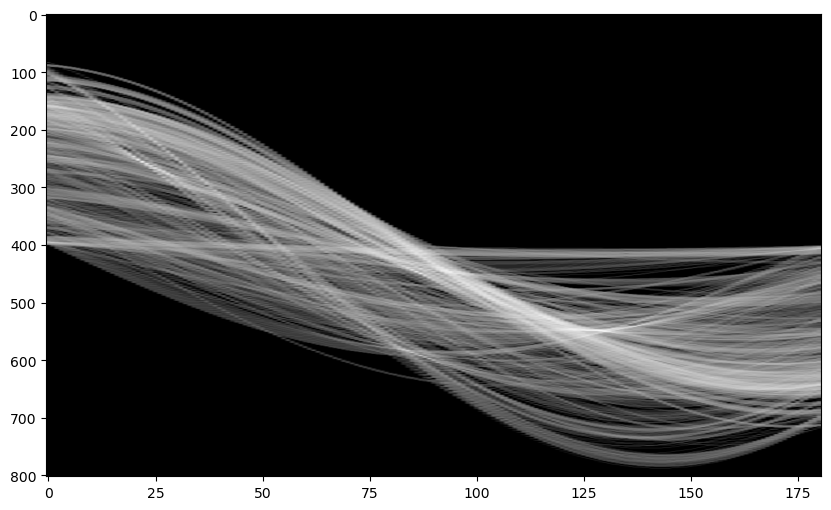

In [23]:
resultados = detecta_rectas(frame1, muestra_matriz= True)

In [13]:
def muestra_linea(imagen, angulo, rho):
    ancho = np.shape(imagen)[1]
    y = np.linspace(0, ancho - 1, ancho)

    x = (rho - y * np.sin(angulo)) / np.cos(angulo)

    plt.ylim(np.shape(imagen)[0], 0)

    plt.title("titulo")
    plt.imshow(imagen, cmap='gray', vmin=0, vmax=255)
    plt.plot(y, x)

In [14]:
def muestra_rectas(imagen, tabla, save = False, indice = 0):
    ancho = np.shape(imagen)[1]
    y = np.linspace(0, ancho - 1, ancho)

    plt.clf()

    plt.ylim(np.shape(imagen)[0], 0)

    plt.title("Lineas rectas - Transformada de Hough")

    plt.imshow(imagen, cmap='gray', vmin=0, vmax=255)
    
    for recta in tabla:
        rho = recta[0]
        ang = recta[1]
        plt.plot(y, (rho - y * np.sin(ang)) / np.cos(ang), linewidth = 5, color = "w")

    if save: plt.savefig('frame_' + str(indice).zfill(5) + '.png')
   


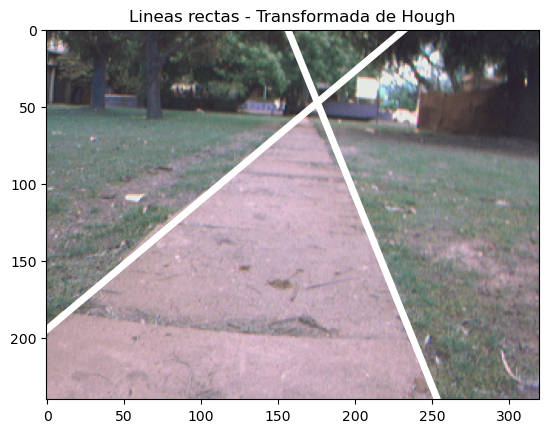

In [15]:
muestra_rectas(frame, resultados, True)

In [30]:
def procesa_video(nombre_video):
    video = cv2.VideoCapture(nombre_video   )
    fps = video.get(cv2.CAP_PROP_FPS)
    
    success, frame = video.read()

    while success:
        numero = np.uint(video.get(cv2.CAP_PROP_POS_FRAMES))
        
        #usamos solo un canal de color
        rectas_detectadas = detecta_rectas(frame[:, :, 0], cant_rectas= 3, umbral_angulo= 2)
        muestra_rectas(frame, rectas_detectadas, save=True, indice= numero)
        print('Read a new frame: ' + str(numero).zfill(5) + " ", success)
        success,frame = video.read()
        if cv2.waitKey(10) == 27:                     # exit if Escape is hit no funciona
            break
    

Read a new frame: 00001  True
Read a new frame: 00002  True
Read a new frame: 00003  True
Read a new frame: 00004  True
Read a new frame: 00005  True
Read a new frame: 00006  True
Read a new frame: 00007  True
Read a new frame: 00008  True
Read a new frame: 00009  True
Read a new frame: 00010  True
Read a new frame: 00011  True
Read a new frame: 00012  True
Read a new frame: 00013  True
Read a new frame: 00014  True
Read a new frame: 00015  True
Read a new frame: 00016  True
Read a new frame: 00017  True
Read a new frame: 00018  True
Read a new frame: 00019  True
Read a new frame: 00020  True
Read a new frame: 00021  True
Read a new frame: 00022  True
Read a new frame: 00023  True
Read a new frame: 00024  True
Read a new frame: 00025  True
Read a new frame: 00026  True
Read a new frame: 00027  True
Read a new frame: 00028  True
Read a new frame: 00029  True
Read a new frame: 00030  True
Read a new frame: 00031  True
Read a new frame: 00032  True
Read a new frame: 00033  True
Read a new

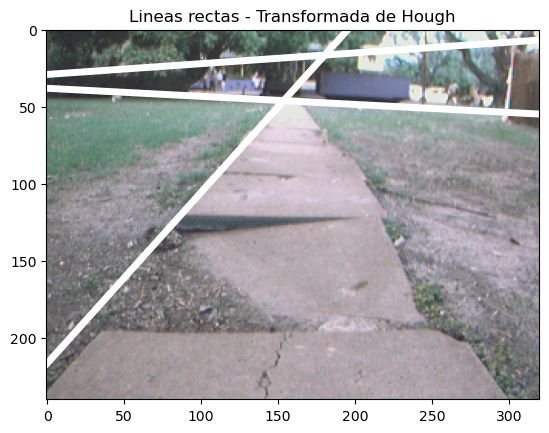

In [31]:
procesa_video("camino1.avi")

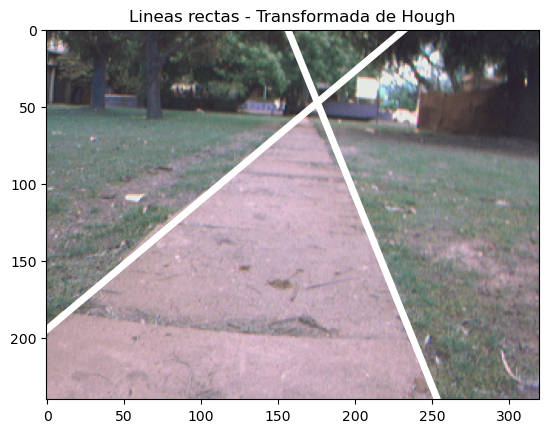

In [48]:
rectas_detectadas = detecta_rectas(frame1, cant_rectas= 2, umbral_angulo= 40)
muestra_rectas(frame, rectas_detectadas)